In [4]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

import lifelines

# Chap 12. 생존분석
## 12.1 중도 절단과 생존 함수

### 생존분석 개요
- 관심있는 어떤 사건이 발생할 때 까지 경과된 시간(time to event)을 분석
- 생존시간 : 사건이 발생할 때까지 걸리는 시간, 사건 정의 방식에 따라 응용분야는 광범위
    - 시간의 흐름에 따라 달라지는 사건발생률의 분포를 분석
    - 사건 발생을 시간의 함수로 모델링하여 일정 시점에서의 생존확률 추정
    - 사건 발생까지의 시간이 집단간에 차이가 있는지 분석
    - 어떠한 변수들이 사건발생까지의 시간에 영향을 미치는지 분석
- 중도절단 : 생존시간 데이터에 포함된 생존분석 특유의 결측값
    - 관측된 기간동안 분석 대상자에게서 사건이 일어나지 않을 때 발생 ex) loss to follow up, drop out, termination of stury, death from unrelated cause
- 생존함수 S(t) : 적어도 (최소한) t 시점까지 생존할 확률 (t 시점을 지나서 생존할 확률)
    - 사건 미발생에 초점
$$S(t) = Pr(T>t0=1-P(t),\quad T:생존시간,\ P(t): T의\ CDF,\ S(0)=1,\ S(\inf)=0$$

$$P(t)=Pr(T\leq t)=\int^t_0 f(t)dt, \quad f(t)는\ T의\ pdf$$
- 위험함수(hazard function, h(t)) : t 시점에 생존한 분석 대상자가 해당 시점에서 사망할 확률(t 시점까지 생존한 환자가 그 시점에서 사망할 조건부확률
    - 사건 발생에 관심
$$h(t) = \lim_{\triangle t \rightarrow 0} \frac{Pr(t\leq T < t+\triangle t|T \gt t)}{\triangle t}$$
$$H(t) = \int^t_0 h(t)dt=-lnS(t),\quad H(t):CDF$$

## 12.2 카플란-마이어 분석
- Kaplan-Meier analysis : 생존시간 데이터가 주어진 경우, 관측된 생존시간으로 부터 생존확률 추정
$$\hat{S}(t)=\prod_{i\leq t}(1-\frac{d_i}{n_i})=p_1\times p_2\times\dots p_{t-1} \times p_t = \hat{S}(t-1)\times p_t$$
$$p_i=1-\frac{d_i}{n_1},각\ 시점에서의\ 생존비율,\ d:사망자수,\ n: 생존자수,\ \hat{S}(t):t시점\ 생존확률\ 추정치$$
- 생존함수곡선 : 시간의 흐름에 따라 누적생존비율(생존함수)이 변해가는 추세 시각적 확인
- 집단간 생존함수 비교 : 로그순위검정
    - H0 : 모든 시점에서 집단간 생존시간의 차이가 없다
    $$\chi^2_{logrank} = \frac{(O_1-E_1)^2}{E_1} + \frac{(O_2-E_2)^2}{E_2},\qquad O:사망관측빈도,\ E:사망 기대빈도$$
    => 두 집단 간 기대빈도와 관측빈도의 차의로 검정
    $$E_1=\sum\frac{d_i}{n_i}n_{1i},\quad d:해당시점\ 사망자수,\ n:해당시점\ 생존자수,\ n_{1i}:i시점\ 집단1\ 생존자수$$

In [99]:
cancer = pd.read_csv("../data/kwak/cancer.csv").drop('rownames', axis=1)
cancer['sex'] = list(map(lambda x : 'male' if x==1 else 'female', cancer['sex']))

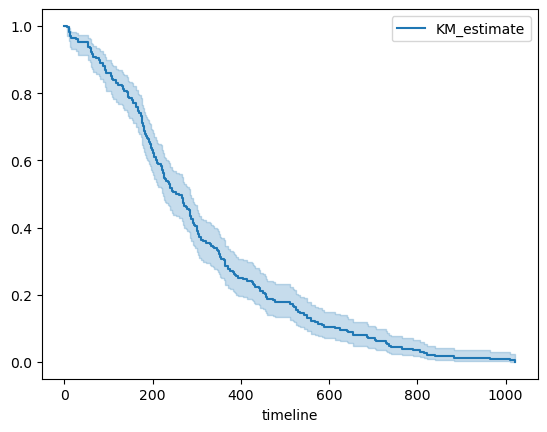

In [100]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(cancer['time'], event_observed=cancer['status'])

kmf_fit.plot_survival_function();

In [32]:
# 필요한 정보
kmf_df = kmf.event_table.copy()
kmf_df['surv'] = kmf.survival_function_

kmf_df

,removed,observed,censored,entrance,at_risk,surv
event_at,,,,,,
0.0,0,0,0,228,228,1.000000
5.0,1,1,0,0,228,0.995614
11.0,3,3,0,0,227,0.982456
12.0,1,1,0,0,224,0.978070
13.0,2,2,0,0,223,0.969298
...,...,...,...,...,...,...
840.0,1,1,0,0,5,0.017544
883.0,1,1,0,0,4,0.013158
965.0,1,1,0,0,3,0.008772


In [39]:
# 특정 시간 생존 확률
kmf.survival_function_at_times(times=[180, 360])

180    0.697368
360    0.307018
Name: KM_estimate, dtype: float64

In [40]:
# 생존 확률 대표값 : 일반적으로 정규분포 기대하기 어려우며, 우꼬리 편향 => 평균 대신 중앙값 사용
kmf.median_survival_time_

252.0

In [48]:
# 특정 %일 때, 경과 일 수
target_percent = 0.3
kmf.survival_function_.loc[kmf.survival_function_['KM_estimate']<=target_percent].index.min()

363.0

male median time : 223.0000
female median time : 292.0000
sex group log-rank test p_val : 0.1467


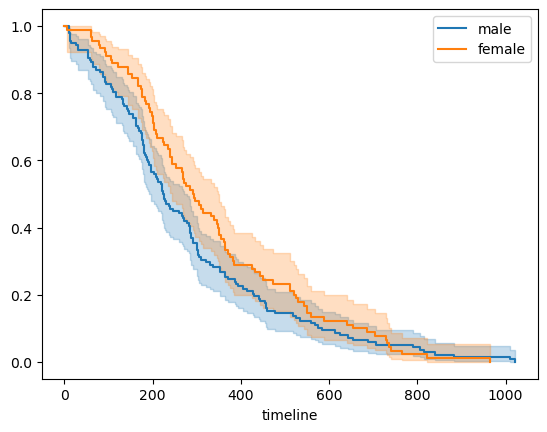

In [66]:
from lifelines.statistics import logrank_test

col = 'sex'
# 성별에 따라 생존 시간의 차이가 있는지 확인
for group in cancer[col].unique():
    group_data = cancer.loc[cancer[col]==group]
    kmf.fit(group_data['time'], event_observed=group_data['status'], label=f"{group}")
    kmf.plot_survival_function()
    print(f"{group} median time : {kmf.median_survival_time_:.4f}")

group_a = cancer.loc[cancer[col]=='male']
group_b = cancer.loc[cancer[col]=='female']

# H0 : no diff
print(f"{col} group log-rank test p_val : {logrank_test(group_a['time'], group_b['time'], event_observed_A=group_a['status'], event_observed_B=group_b['status']).p_value:.4f}")

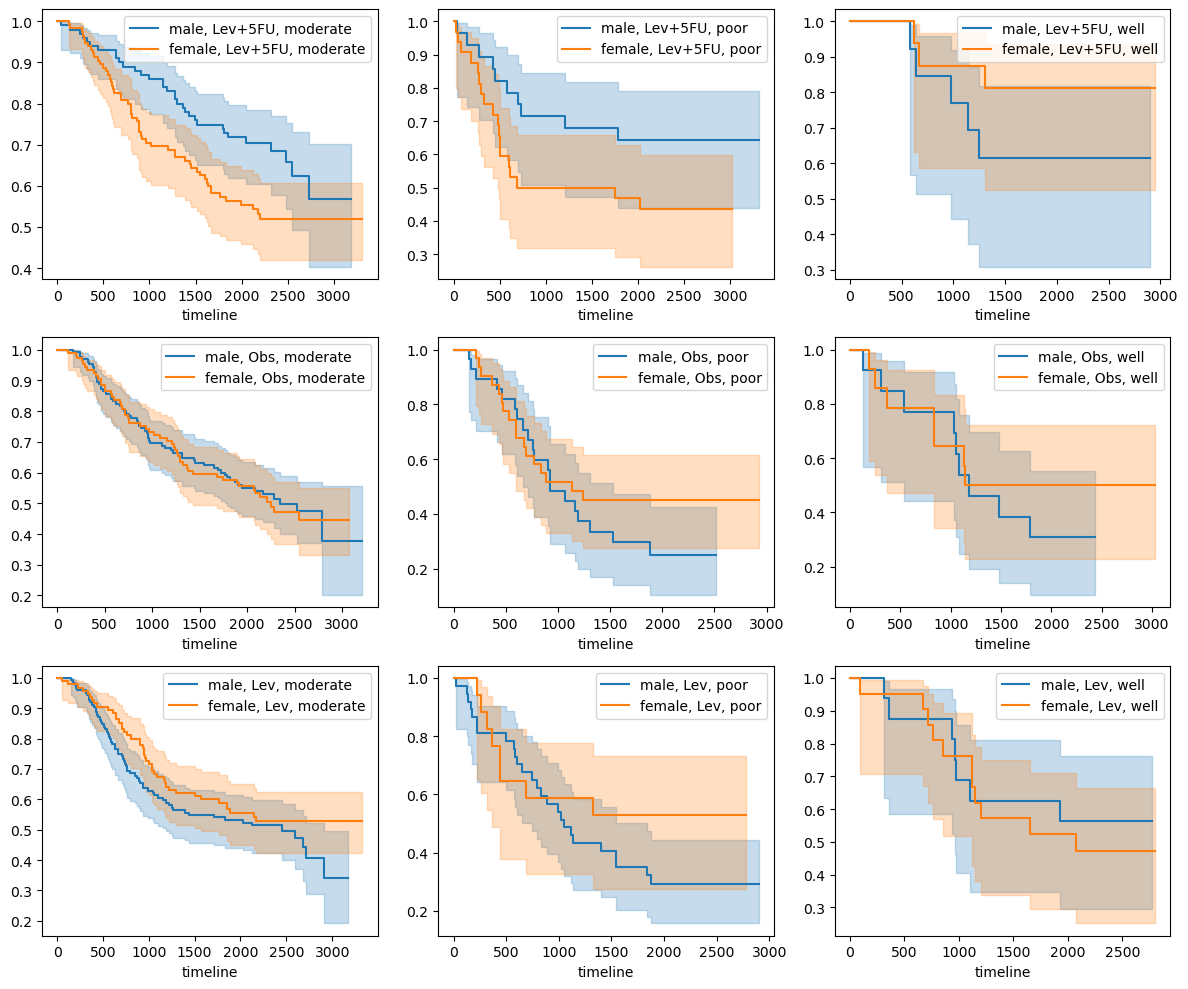

In [98]:
# 다중 집단에 대한 카플란 분석
colon = pd.read_csv('../data/kwak/colon.csv').drop('rownames', axis=1)

colon_death = colon.loc[colon['etype']==2] # 사망의 경우만 사용
colon_death['sex'] = list(map(lambda x : 'male' if x == 1 else 'female', colon_death['sex']))
colon_death['differ'] = list(map(lambda x : 'well' if x == 1 else ('moderate' if x == 2 else 'poor'), colon_death['differ']))

fig, axes = plt.subplots(3,3, figsize=(12,10))
i = 0
for rx in colon_death['rx'].unique():
    for differ in colon_death['differ'].unique():
        i = i + 1
        for sex in colon_death['sex'].unique():
            subset = colon_death.loc[(colon_death['sex']==sex) & (colon_death['rx']==rx) & (colon_death['differ']==differ)]
            if subset.empty:
                continue
            kmf.fit(subset['time'], event_observed=subset['status'], label=f'{sex}, {rx}, {differ}')
            kmf.plot_survival_function(ci_show=True, ax=axes[(i-1)//3, (i-1)%3])

plt.tight_layout()            
plt.show()

In [82]:
from lifelines.statistics import pairwise_logrank_test

result = pairwise_logrank_test(colon_death['time'], groups=colon_death['sex'] + '|' + colon_death['rx'] + '|' + colon_death['differ'], event_observed=colon_death['status'])
result.summary

test_statistic         p  \
female|Lev+5FU|moderate female|Lev+5FU|poor        2.710213  0.099708   
                        female|Lev+5FU|well        3.923823  0.047607   
                        female|Lev|moderate        0.019267  0.889602   
                        female|Lev|poor            0.210399  0.646455   
                        female|Lev|well            0.132704  0.715645   
...                                                     ...       ...   
male|Lev|well           male|Obs|poor              4.237609  0.039538   
                        male|Obs|well              1.505088  0.219890   
male|Obs|moderate       male|Obs|poor              8.706385  0.003171   
                        male|Obs|well              2.417673  0.119973   
male|Obs|poor           male|Obs|well              0.304416  0.581127   

                                             -log2(p)  
female|Lev+5FU|moderate female|Lev+5FU|poor  3.326152  
                        female|Lev+5FU|well  4.392697  
                        female|Lev|moderate  0.168767  
                        female|Lev|poor      0.629378  
                        female|Lev|well      0.482685  
...                                               ...  
male|Lev|well           male|Obs|poor        4.660623  
                        male|Obs|well        2.185145  
male|Obs|moderate       male|Obs|poor        8.300858  
                        male|Obs|well        3.059218  
male|Obs|poor           male|Obs|well        0.783074  

[153 rows x 3 columns]

## 12.3 콕스 회귀분석
- Cox regression analysis : 생존시간과 하나 이상의 예측변수 간의 관계를 분석하는 일종의 회귀분석 모델 
- 범주형 변수 뿐만 아니라 연속형 변수가 생존시간에 미치는 영향을 분석할 수 있는 다변량분석
- 일반적인 다중회귀분석에서 처럼 복수의 요인을 동시에 통계모델에 투입함으로써 모델에 포함된 **다른 예측변수들이 일정하다는 가정**하에 각 예측변수가 사건발생률에 미치는 영향 분석
$$h(t) = h_0(t)\times e^{b_1x_1+\dots+b_px_p},\quad h(t):위험률,\ h_0(t):t시점\ 베이스\ 위험률$$
$$ ln(\frac{h(t)}{h_0(t)})=b_1x_1+\dots+b_px_p, \\\frac{h(t)}{h_0(t)}=e^{b_1x_1+\dots+b_px_p}=e^{b_1x_1}\dots e^{b_px_p}$$
- 위험비(hazard ratio) : 예측변수 한 단위가 증가할 때 변화하는 위험률
    - 한 환자는 $x_1$ 변수값이 k이고 다른 환자는 k+1일 떄의 두 환자에 데한 위험비
    $$\frac{\frac{h(t|x_1=k+1)}{h_0(t)}}{\frac{h(t|x_1=k)}{h_0(t)}}=\frac{h(t|x_1=k+1)}{h(t|x_1=k)}=\frac{e^{b_1(k+1)+b_2x_2+\dots+b_px_p}}{e^{b_1k+b_2x_2+\dots+b_px_p}} =\frac{e^{b_1(k+1)}}{e^{b_1k}}=e^{b_1}$$
    => $x_1$이 5 증가하면? $\frac{e^{b_1(k+5)}}{e^{b_1k}}=e^{b_1\times 5}=(e^{b_1})^5$
    - 위험비($e^{b_1}$) & 위험률 간의 관계
        1) 위험비 > 1(b_i > 0) : 위험률 증가
        2) 위험비 = 1(b_i = 0) : 영향 없음
        3) 위험비 < 1(b_i < 0) : 위험률 감소
    - 비례위험가정 (proportional hazards assumption) : 콕스 회귀분석은 위험비가 생존기간 내내 일정하다고 가정 **[시간에 의한 변화 없음]**
- z : wald 통계량, 회귀계수/표준오차
    - Wald test H0 : 회귀계수 0
    - 위험비가 1이면 회귀계수 0 => 신뢰구간 내 0 이 있을 경우 통계적으로 유의하지 않음

In [110]:
from lifelines import CoxPHFitter

cancer = pd.read_csv("../data/kwak/cancer.csv").drop('rownames', axis=1)
cancer_temp = cancer[['time', 'status', 'age', 'sex', 'ph.ecog']].dropna()

cph = CoxPHFitter()
cph.fit(cancer_temp, duration_col = 'time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 227
   partial log-likelihood = -1002.38
         time fit was run = 2025-01-04 13:18:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
sex        -0.21       0.81       0.14            -0.48             0.05                 0.62                 1.06
ph.ecog     0.30       1.35       0.10             0.10             0.49                 1.11                 1.63

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  0.09   0.93       0.10
sex           0.00 -1.56   0.12       3.08
ph.ecog       0.00  3.01 <0.005       8.56
---
Concordance = 0.59
Partial AIC = 2010.75
log-likelihood ratio test = 11.44 on 3 df
-log2(p) of ll-ratio test = 6.71

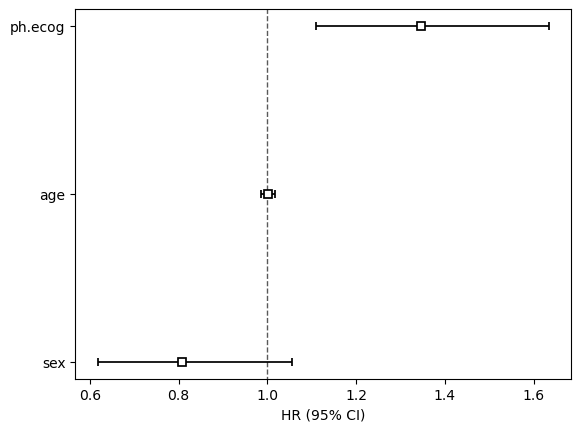

In [123]:
cph.plot(hazard_ratios=True);

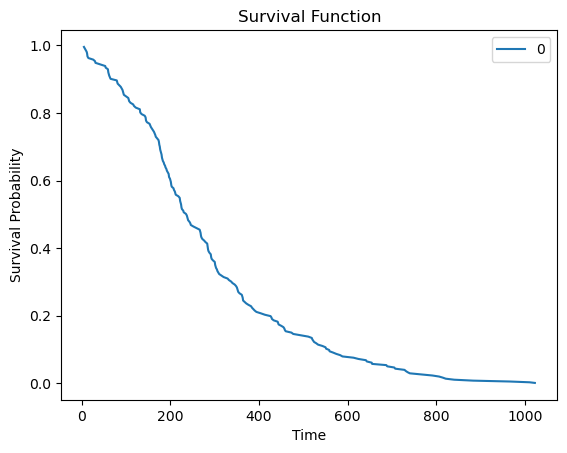

In [135]:
# 특정 개인의 생존 확률 예측
individual_data = cancer_temp.iloc[0:2]
median_data = cancer_temp.median().to_frame().T
survival_function = cph.predict_survival_function(median_data)

# 생존 함수 플롯
survival_function.plot(title="Survival Function", xlabel="Time", ylabel="Survival Probability");

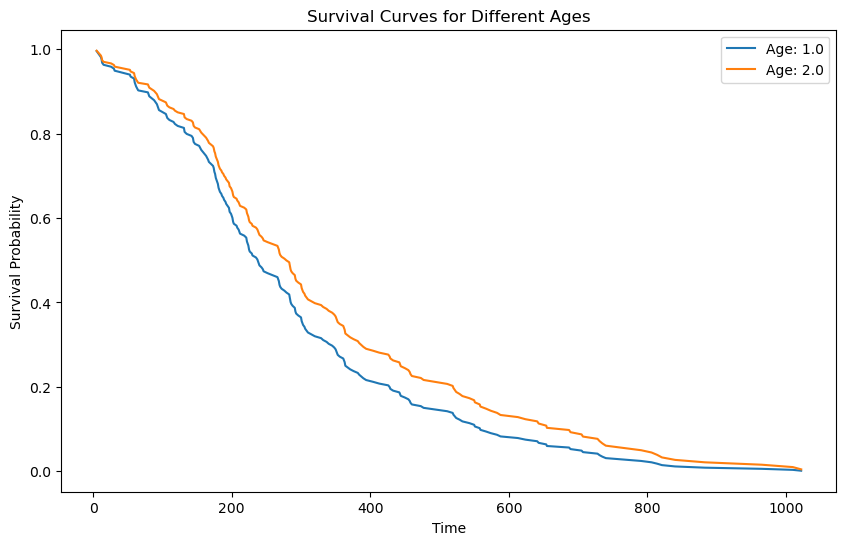

In [160]:
# 특정 예측변수(sex)가 생존확률에 미치는 영향
cancer_sex = pd.DataFrame(np.zeros((2,3)), columns=['sex', 'age', 'ph.ecog'])
cancer_sex['sex'][0] = 1 # female
cancer_sex['sex'][1] = 2 # male
cancer_sex['age'] = cancer_temp['age'].mean()
cancer_sex['ph.ecog'] = cancer_temp['ph.ecog'].mean()

surv_curves = cph.predict_survival_function(cancer_sex)

plt.figure(figsize=(10, 6))
for i, sex in enumerate(cancer_sex['sex'].unique()):
    plt.plot(surv_curves.index, surv_curves.iloc[:, i], label=f'Age: {sex}')

plt.title('Survival Curves for Different Ages'); 
plt.xlabel('Time'); plt.ylabel('Survival Probability');
plt.legend()
plt.show()    

In [161]:
# 비례위험가정 위반 여부 확인 : 잔차 기반 통계검증
# => 시간의 변화에 따라 잔차의 규칙적인 패턴이 발견되면 가정 위반
cph.check_assumptions(cancer_temp, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 227 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic    p  -log2(p)
age     km              0.78 0.38      1.41
        rank            0.78 0.38      1.41
ph.ecog km              4.63 0.03      4.99
        rank            4.63 0.03      4.99
sex     km              5.37 0.02      5.61
        rank            5.36 0.02      5.60



1. Variable 'sex' failed the non-proportional test: p-value is 0.0205.

   Advice: with so few unique values (only 2), you can include `strata=['sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'ph.ecog' failed the non-proportional test: p-value is 0.0314.

   Advice 1: the functional form of the variable 'ph.ecog' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ph.ecog' using pd.cut, and then specify it in
`strata=['ph.ecog', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthe

[]

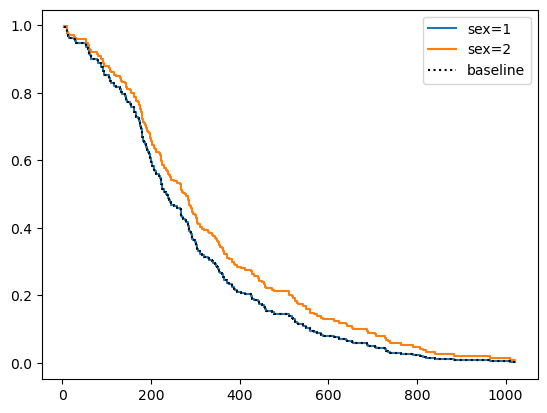

In [163]:
cph.plot_partial_effects_on_outcome(covariates='sex', values=[1,2]);